In [1]:
import json
import pandas as pd
import numpy as np

# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import mlflow
import matplotlib.pyplot as plt
from pathlib import Path
import socket
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras


PATH = Path('CMAPSSData/')
TEST_DATA = PATH/'test_FD001.txt'
MODEL_PORT = 10752
DATA_PORT = 10753

TIME_OUT = 3
MODEL_NAME = "regression_loss_50"
TEST_FILE = "CMAPSSData/test_FD001.txt"
RUL_FILE = "CMAPSSData/RUL_FD001.txt"
RESULT = "re_loss_50_result.txt"

FILE_NAME = "re_train.txt"
DATA_TMP = "re_rec.txt"
ORIGIN_DATA = 'CMAPSSData/train_FD001.txt'
TEST_DATA = 'CMAPSSData/test_FD001.txt'
TIME_OUT = 3
MODEL_NAME = "regression_test"
REMAIN_NUM = 100

2023-03-30 16:39:40.042559: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-30 16:39:40.101162: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-30 16:39:40.357088: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-30 16:39:40.359410: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 16:39:41.497805: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
def reload_model(model_name:str, model_version:str = None) -> mlflow.pyfunc.PyFuncModel:
    '''
    The models are stored in the MLflow tracking server.
    Fetch the latest model
    '''
    if model_version:
        model = mlflow.pyfunc.load_model(
            model_uri=f"models:/{model_name}/{model_version}"
        )
    else:
        model = mlflow.pyfunc.load_model(
            model_uri=f"models:/{model_name}/Production"
        )
    return model

def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means
    we need to drop those which are below the window-length. """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

# function to generate label_array
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

def data_load(sequence_length=25):
    # Read data from txt file
    test_df = pd.read_csv(TEST_FILE, sep=" ", header=None)
    test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
    test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                        's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                        's15', 's16', 's17', 's18', 's19', 's20', 's21']
    # read ground truth data
    truth_df = pd.read_csv(RUL_FILE, sep=" ", header=None)
    truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
    rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']
    truth_df.columns = ['more']
    truth_df['id'] = truth_df.index + 1
    truth_df['max'] = rul['max'] + truth_df['more']
    truth_df.drop('more', axis=1, inplace=True)
    test_df = test_df.merge(truth_df, on=['id'], how='left')
    test_df['RUL'] = test_df['max'] - test_df['cycle']
    test_df.drop('max', axis=1, inplace=True)
    # generate label1 column for test data
    test_df['label1'] = np.where(test_df['RUL'] <= 30, 1, 0 )
    scaler = preprocessing.MinMaxScaler()
    # MinMax normalization for test data
    test_df['cycle_norm'] = test_df['cycle']
    scaler_column = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
    for col in scaler_column:
        test_df[[col]] = scaler.fit_transform(test_df[[col]])
    # pick the feature columns 
    sensor_cols = ['s' + str(i) for i in range(1,22)]
    sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
    sequence_cols.extend(sensor_cols)
    seq_array_test_last = (list(gen_sequence(test_df[test_df['id']==id], sequence_length, sequence_cols))
                           for id in test_df['id'].unique())
    seq_array_test_last = np.concatenate(list(seq_array_test_last)).astype(np.float32)
    label_array_test_last = (gen_labels(test_df[test_df['id']==id], sequence_length, ['RUL'])
                             for id in test_df['id'].unique())
    label_array_test_last = np.concatenate(list(label_array_test_last)).astype(np.float32)
    # seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
    #                     for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]
    # seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
    # # Last cycle test data - seq_array for test data
    print(seq_array_test_last.shape)
    # y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
    # label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
    # label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
    return seq_array_test_last, label_array_test_last


def eval_model(model:mlflow.pyfunc.PyFuncModel, testdata, testlabel):
    mae = keras.losses.MeanAbsoluteError()
    label_pre = model.predict(testdata)[:,0]
    result_mae = mae(testlabel, label_pre)
    # print(label_pre)
    # print(testlabel)
    pre_mae = 'reult is:' + str(result_mae.numpy()) + '\n'
    # print(pre_mae)
    return label_pre, result_mae.numpy()


In [3]:
mlflow.set_tracking_uri("http://localhost:5000")

In [4]:
test_data, test_label = data_load()

(14096, 25, 25)


In [77]:
model = reload_model(model_name = 'regression_loss_10',model_version=67)

/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [14]:
sum_mae = 0
for i in np.arange(30)+38:
    print(i)
    model = reload_model(model_name = 'regression_loss_50',model_version=i)
    label_pre, result_mae = eval_model(model,test_data,test_label)
    sum_mae += result_mae
print("Average mae:", sum_mae/30)

38


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step
39


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
40


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step
41


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
42


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step
43


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
44


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 4s 6ms/step
45


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
46


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
47


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
48


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
49


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
50


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
51


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
52


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step
53


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step
54


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step
55


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
56


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step
57


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step
58


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
59


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
60


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
61


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step
62


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
63


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
64


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
65


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step
66


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
67


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step
Average mae: 105.70060246785482


In [46]:
model = reload_model(model_name = 'regression_loss_0',model_version=5)
label_pre_0, result_mae = eval_model(model,test_data,test_label)
model = reload_model(model_name = 'regression_loss_15',model_version=57)
label_pre_15, result_mae = eval_model(model,test_data,test_label)
model = reload_model(model_name = 'regression_loss_25',model_version=47)
label_pre_25, result_mae = eval_model(model,test_data,test_label)
model = reload_model(model_name = 'regression_loss_15',model_version=45)
label_pre_50, result_mae = eval_model(model,test_data,test_label)

/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 6ms/step


In [55]:
model = reload_model(model_name = 'regression_loss_0',model_version=16)
label_pre_0, result_mae = eval_model(model,test_data,test_label)

/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


441/441 [==============================] - 3s 7ms/step


Text(0.5, 1.0, '50%')

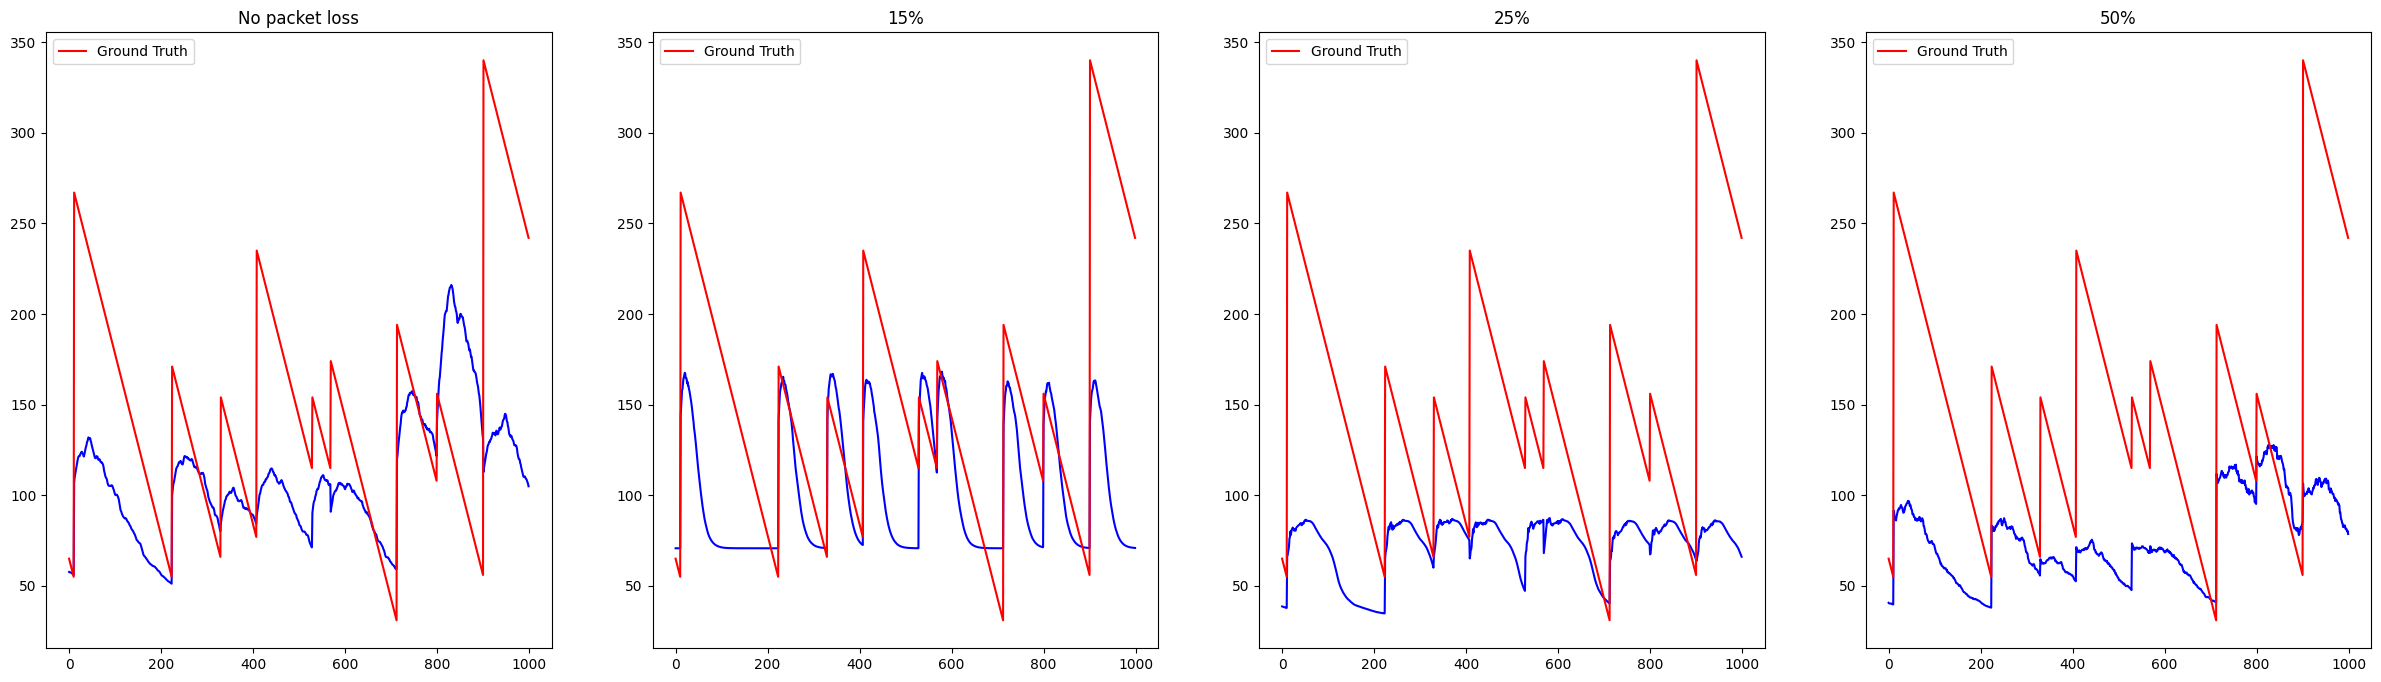

In [58]:
plt.figure(figsize=(30,8))
ax = plt.subplot(1,4,1)
ax.plot(np.arange(1000),label_pre_0[1000:2000],'b')
ax.plot(np.arange(1000),test_label[1000:2000],'r',label='Ground Truth')
ax.legend()
ax.set_title('No packet loss')

ax = plt.subplot(1,4,2)
ax.plot(np.arange(1000),label_pre_15[1000:2000],'b')
ax.plot(np.arange(1000),test_label[1000:2000],'r',label='Ground Truth')
ax.legend()
ax.set_title('15%')

ax = plt.subplot(1,4,3)
ax.plot(np.arange(1000),label_pre_25[1000:2000],'b')
ax.plot(np.arange(1000),test_label[1000:2000],'r',label='Ground Truth')
ax.legend()
ax.set_title('25%')

ax = plt.subplot(1,4,4)
ax.plot(np.arange(1000),label_pre_50[1000:2000],'b')
ax.plot(np.arange(1000),test_label[1000:2000],'r',label='Ground Truth')
ax.legend()
ax.set_title('50%')

In [154]:
def cl_data_load(sequence_length=25):
    # Read data from txt file
    test_df = pd.read_csv(TEST_FILE, sep=" ", header=None)
    test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
    test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                        's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                        's15', 's16', 's17', 's18', 's19', 's20', 's21']
    # read ground truth data
    truth_df = pd.read_csv(RUL_FILE, sep=" ", header=None)
    truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
    rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']
    truth_df.columns = ['more']
    truth_df['id'] = truth_df.index + 1
    truth_df['max'] = rul['max'] + truth_df['more']
    truth_df.drop('more', axis=1, inplace=True)
    test_df = test_df.merge(truth_df, on=['id'], how='left')
    test_df['RUL'] = test_df['max'] - test_df['cycle']
    test_df.drop('max', axis=1, inplace=True)
    # generate label1 column for test data
    test_df['label1'] = np.where(test_df['RUL'] <= 30, 1, 0 )
    scaler = preprocessing.MinMaxScaler()
    # MinMax normalization for test data
    test_df['cycle_norm'] = test_df['cycle']
    scaler_column = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
    for col in scaler_column:
        test_df[[col]] = scaler.fit_transform(test_df[[col]])
    # pick the feature columns 
    sensor_cols = ['s' + str(i) for i in range(1,22)]
    sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
    sequence_cols.extend(sensor_cols)
    seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                        for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]
    seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
    # Last cycle test data - seq_array for test data
    print(seq_array_test_last.shape)
    y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
    label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
    label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
    return seq_array_test_last, label_array_test_last

def cl_eval_model(model:mlflow.pyfunc.PyFuncModel, testdata, testlabel):
    target_name = ['Normal','Broken']
    label_pre = model.predict(testdata)
    # Set the threshold = 0.5
    label_pre = (label_pre>0.5).astype(np.int64)
    label_pre = label_pre[:,1]
    accuracy = np.sum(label_pre==testlabel) / label_pre.shape[0]
    pr_acc = "Accuracy is:" + str(accuracy) + "\n"
    # print(pr_acc)
    result = confusion_matrix(testlabel, label_pre,normalize='pred')
    # print("Confusion matrix is:\n",result,"\n")
    report = classification_report(testlabel, label_pre, target_names=target_name)
    pr_rep = "Classification report:\n" + report
    # print(pr_rep)
    return accuracy, result, pr_rep

In [122]:
cl_test_data, cl_test_label = cl_data_load()
target_name = ['Normal','Broken']

(100, 25, 25)


In [173]:
accuracy = 0
for i in np.arange(30)+38:
    model = reload_model(model_name = 'classification_loss_45',model_version=i)
    tmp_accuracy, result, pr_rep = cl_eval_model(model,cl_test_data,cl_test_label)
    accuracy += tmp_accuracy
    print(i)
    # if accuracy != '0.8':
    #     print(f'Model {i}: ',accuracy)
    #     print(result)
    #     print(pr_rep)
print("Average accuracy:", accuracy/30)

/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


4/4 [==============================] - 0s 5ms/step
38


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 5ms/step
39


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 6ms/step
40


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 5ms/step
41


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 6ms/step
42


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 6ms/step
43


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 4ms/step
44


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 5ms/step
45


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 4ms/step
46


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 5ms/step
47


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 4ms/step
48


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 4ms/step
49


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 5ms/step
50


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 4ms/step
51


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 4ms/step
52


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 5ms/step
53


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 4ms/step
54


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 4ms/step
55


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 4ms/step
56


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 4ms/step
57


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 5ms/step
58


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 4ms/step
59


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 7ms/step
60


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 5ms/step
61


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 7ms/step
62


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 6ms/step
63


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 6ms/step
64


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 5ms/step
65


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 5ms/step
66


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

4/4 [==============================] - 0s 4ms/step
67
Average accuracy: 0.8000000000000004


/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r